In [72]:
import torch
import dgl
import networkx as nx
import numpy as np

In [73]:
def draw_graph(G): # G is a DGL graph
    nx_G = G.to_networkx()
    labels = {}
    for i in range(len(G.ndata['spins'])):
        labels[i] = int(G.ndata['spins'][i].item())
    nx.draw(nx_G, labels=labels, directed=False)

In [74]:
def generate_spin_graphs(num_graphs, min_n, max_n, 
                            min_p, max_p):
    """
    Generates a set of random graphs and random spins.
    min_n - minimum number of nodes in any graph
    max_n - maximum number of nodes in any graph
    min_p - minimum probability of an edge being between any two nodes
    max_p - maximum probability of an edge being between any two nodes
    """

    samples = []

    for i in range(num_graphs):

        n = int((max_n-min_n) * np.random.random_sample() + min_n)
        p = (max_p-min_p) * np.random.random_sample() + min_p

        G = nx.fast_gnp_random_graph(n, p, seed=None, directed=False)
        G = dgl.DGLGraph(G)

        spins = np.random.choice([1,-1], n, replace=True)
        spins = torch.tensor(spins).float().view(-1, 1)

        G.ndata['spins'] = spins

        samples.append(G)


    return samples

DGL graphs are directed by default. To make an undirected graph you add the reverse edge in each case. It is for that reason that we must add 0.5 * for each iteration of the loop below.

In [92]:
def calculate_hamiltonian_simple(G, J):
    """
    G - DGLGraph
    J - Interaction strength (float)
    """
    src, dst = G.all_edges()
    spins = G.ndata['spins']
    total = 0
    for i in range(len(src)):
        total -= 0.5 * spins[src[i].item()].item() * spins[dst[i].item()].item()
    return J * total

In [106]:
batch = generate_spin_graphs(5, 5,6,0.5,0.5)

Hamiltonian (J=1): 1.0


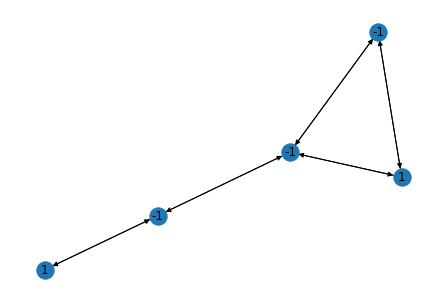

In [108]:
G = batch[0]
draw_graph(G)
print("Hamiltonian (J=1):", calculate_hamiltonian_simple(G, 1))

Hamiltonian (J=1): 2.0


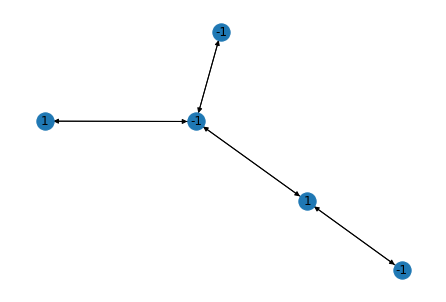

In [105]:
G = batch[1]
draw_graph(G)
print("Hamiltonian (J=1):", calculate_hamiltonian_simple(G, 1))

Hamiltonian (J=1): 2.0


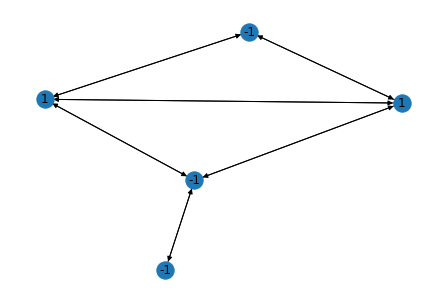

In [109]:
G = batch[2]
draw_graph(G)
print("Hamiltonian (J=1):", calculate_hamiltonian_simple(G, 1))

Hamiltonian (J=1): 3.0


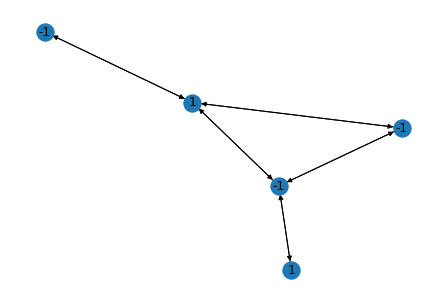

In [111]:
G = batch[3]
draw_graph(G)
print("Hamiltonian (J=1):", calculate_hamiltonian_simple(G, 1))

Hamiltonian (J=1): -4.0


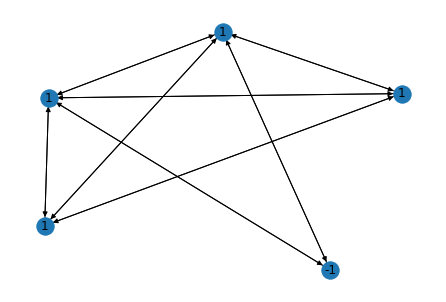

In [112]:
G = batch[4]
draw_graph(G)
print("Hamiltonian (J=1):", calculate_hamiltonian_simple(G, 1))

In [64]:
import networkx as nx
import numpy.linalg 
import numpy as np
Nbound=10 #we choose a uniform bound for sampling number of edges and vertices
num_iter=10 #just how many random graphs you want
graph_spec_detail=[] #this will be the list of elements '[w,z]' where w is the graph and z is the assoc spectra
def graph_eigens(graph):
  '''
  The input is the graph, and the output is a normalized spectrum of the graph using the functions on 'Networkx'.
  '''
  return nx.normalized_laplacian_spectrum(graph)

def graph_spec_generator(N_lower, N_upper, num_iter):
  '''
  The input here is the uniform sampling bound introduced above, and the number of sampling iterations. For each iteration, we choose
  an m and an n, the size and order, then we generate a random graph. Then we use the 'graph_eigens' to compute the spectra for this graph, and we 
  store the data in graph_spec_detail in the form '[w,z]' as mentioned above.
  '''
  for index in range(1,num_iter):
    n = np.random.randint(N_lower, N_upper)
    Mbound = n *(n-1) // 2 # complete graph
    m = np.random.randint(1,Mbound)
    g=nx.gnm_random_graph(n, m)
    graph_spec_detail.append([g, max(graph_eigens(g))]) # made it return only the largest eigen value
    
  return graph_spec_detail

In [26]:
graphs = graph_spec_generator(10, 10)

In [27]:
graphs

[[<networkx.classes.graph.Graph at 0x7fa4ed8746d8>, 1.666666666666667],
 [<networkx.classes.graph.Graph at 0x7fa4ed874438>, 1.72871355387817],
 [<networkx.classes.graph.Graph at 0x7fa4ed874898>, 1.5776551386251612],
 [<networkx.classes.graph.Graph at 0x7fa4ed874cf8>, 1.6666666666666667],
 [<networkx.classes.graph.Graph at 0x7fa4ed8747f0>, 1.5886464093297061],
 [<networkx.classes.graph.Graph at 0x7fa4ed8746a0>, 1.6822430326023312],
 [<networkx.classes.graph.Graph at 0x7fa4ed874fd0>, 1.8098771001298217],
 [<networkx.classes.graph.Graph at 0x7fa4ed874710>, 1.5595695936834453],
 [<networkx.classes.graph.Graph at 0x7fa4ed874d68>, 2.0]]

1.72871355387817


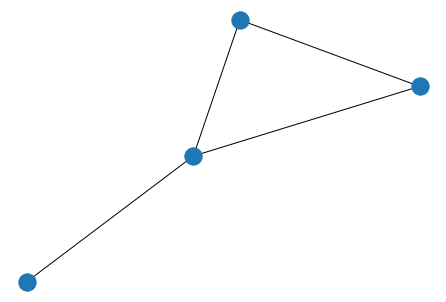

In [58]:
G = graphs[1][0]
nx.draw(G)
print(graphs[1][1])

In [38]:
print(G.edges())

zip(*G.edges())

[(0, 3), (0, 1), (0, 2), (1, 4), (1, 3), (2, 4), (2, 3), (3, 4)]


In [43]:
def append_to_txt(filename, graph_eigen_list):
    lines = []
    for graph, eigen in graph_eigen_list:
        edges = graph.edges()
        # This has shape [(0, 3), (0, 1), (0, 2), (1, 4), (1, 3), (2, 4), (2, 3), (3, 4)]
        
        src = ''
        dst = ''
        for e in edges:
            src += str(e[0]) + " "
            dst += str(e[1]) + " "
        src += "\n"
        dst += "\n"
        eigen = str(eigen) + "\n"
        
        lines.append(eigen)
        lines.append(src)
        lines.append(dst)
        
    file = open(filename, 'a')
    file.writelines(lines)
    file.close()

In [44]:
append_to_txt("eigen_data.txt", graphs)

In [52]:
import dgl

def load_dgl_from_txt(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    graphs = []
    eigens = []
    for i in range(0, len(lines), 3):
        eigen = float(lines[i].strip())
        eigens.append(eigen)
        
        src = list(map(int, lines[i+1].strip().split()))
        dst = list(map(int, lines[i+2].strip().split()))
        u = np.array(src + dst)   #make the edges bi-directional
        v = np.array(dst + src)
        graph = dgl.DGLGraph((u,v))
        graphs.append(graph)
        
    return graphs, eigens

In [55]:
dgl_graphs, labels = load_dgl_from_txt("eigen_data.txt")

In [56]:
labels[1]

1.72871355387817

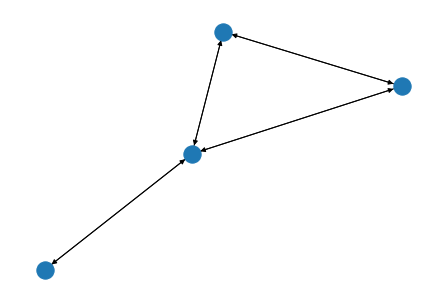

In [61]:
nx.draw(dgl_graphs[1].to_networkx())

In [65]:
graph_specs = graph_spec_generator(10, 20, 100)
append_to_txt("eigen_data.txt", graph_specs)

In [66]:
graphs, eigens = load_dgl_from_txt("eigen_data.txt")

DGLError: Invalid edge list. Nodes must start from 0.